
Total number of glucose readings is: 8057

Some of points may be missing, the above number represents the collected readings from start to end date

Remove NaN from the mg/dL column... 
Total actual number of glucose readings is: 7915

Remove NaN from the CHO so we can plot the points of meals...
Total number of meal times: 325

Some of the successive meal readings stand for one meal only with many servings

Add succesive meal readings (CHO, fat, protein) and store under one recording...

There are 109 recorded meal times.

                 Date  mg/dL  CHO (g)  Fat (g)  Protein (g)
0 2008-08-04 19:07:00   96.0  120.777  23.7115       59.798
1 2008-08-05 07:02:00  112.0   28.209   7.0635        6.562
2 2008-08-05 12:02:00   90.0   30.380   9.2195       32.022
3 2008-08-05 16:47:00   84.0   14.310   0.3800        1.370
4 2008-08-05 19:52:00  105.0   89.430  24.7800       37.490


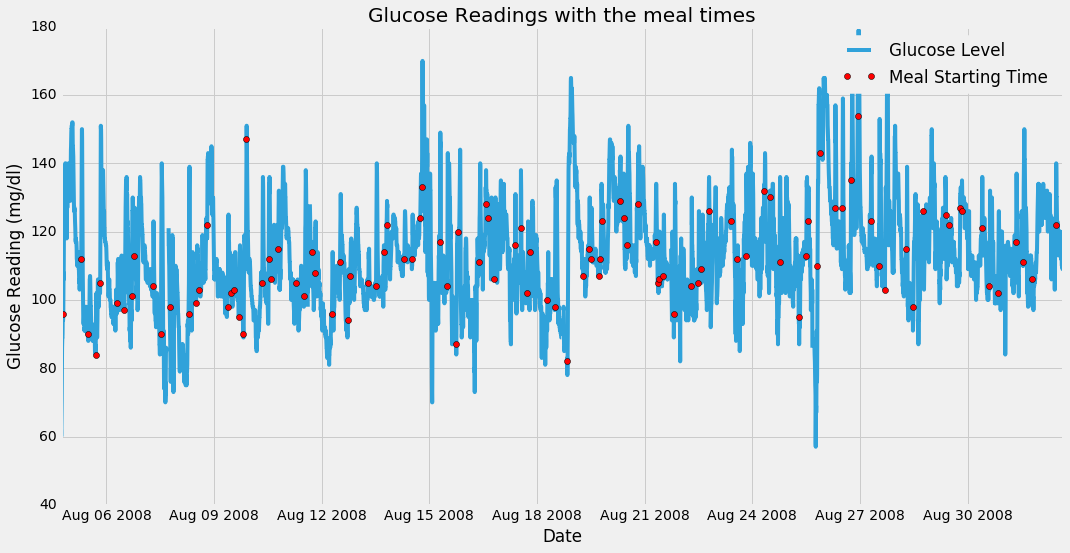

In [23]:
#This was written in Python 2, if you are running Python 3, use a code translation library

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date, time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math

%matplotlib inline
#This is graph line style, from Nate silver
plt.style.use('fivethirtyeight')

#This is for the interactive plotting using bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models.markers import Asterisk
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
from bokeh.models import HoverTool

#My mac directory path
#_DATA_DIR = r'/Users/Salim/Desktop/Diabetes Project/Input/input'
#_FIG_DIR = r'/Users/Salim/Desktop/Diabetes Project/figures'

#My win directory path
_DATA_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\Input\input'
_FIG_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\figures'

if not os.path.exists(_FIG_DIR):
    os.makedirs(_FIG_DIR)
    
_GULCOSE_DATA_PATH = os.path.join(_DATA_DIR, 'P4.csv')
fields = ["Date", "mg/dL", "CHO (g)", "Fat (g)", "Protein (g)"]
df_P = pd.read_csv(_GULCOSE_DATA_PATH, parse_dates=['Date'], usecols = fields) #read and prase Date col as dataTimes object
df_P = df_P.sort(['Date'])

## Matplotlib Variables
_FIG_SIZE = (16, 8)
_FIG_FORMAT = 'png'
_FIG_DPI = 200

def _file_format(string_):
    string_ = string_.replace('-', '_').replace(' ', '_').replace('$', '')
    string_ += '.' + _FIG_FORMAT
    return string_

#For printing full elements of dataframe or array
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

#Print some information about the data    
print "\nTotal number of glucose readings is:", df_P['mg/dL'].size
print "\nSome of points may be missing, the above number represents the collected readings from start to end date"

#Removing NaN from a specific column of the dataframe, here it's mg/dL
df_P_wonan_mg = df_P.dropna(subset=['mg/dL'])
print "\nRemove NaN from the mg/dL column...", "\nTotal actual number of glucose readings is:", df_P_wonan_mg['mg/dL'].size

#Converting object type to float for all of the dataframe (df_Pv2 stands for dataframe, patient, version 2)
df_Pv2= pd.DataFrame(df_P_wonan_mg).convert_objects(convert_numeric=True)

print "\nRemove NaN from the CHO so we can plot the points of meals..."
df_Pv2 = df_Pv2.dropna(subset=['CHO (g)'])
print "Total number of meal times:", df_Pv2['CHO (g)'].size

print "\nSome of the successive meal readings stand for one meal only with many servings"

df_Pv2 = df_Pv2.reset_index(drop=True)

df_P_meals = copy.deepcopy(df_Pv2)

print '\nAdd succesive meal readings (CHO, fat, protein) and store under one recording...\n' 
row = 0

#Combine the successive meals: if the minute difference is 5 minutes then combine

i = 0   
while (i < (df_Pv2['CHO (g)'].size-1)):

    k = i
    #print "Meal time is:", df_Pv2.Date[i]
        
    row = row + 1         
    
    minutesdiff = df_Pv2.Date[k+1] - df_Pv2.Date[k]
    #If the meals are within 30 minutes of each other, combine into one
    while ((minutesdiff.seconds / 60 <= 30)):
        #drop this row but add CHO and fats and proteins to values of previous row
        #print "add"
        k = k+1
        df_P_meals.set_value(row-1,'CHO (g)',df_P_meals['CHO (g)'][row-1]+df_P_meals['CHO (g)'][row])
        df_P_meals.set_value(row-1,'Fat (g)',df_P_meals['Fat (g)'][row-1]+df_P_meals['Fat (g)'][row])
        df_P_meals.set_value(row-1,'Protein (g)',df_P_meals['Protein (g)'][row-1]+df_P_meals['Protein (g)'][row])
        df_P_meals.drop(df_P_meals.index[row], axis=0, inplace=True)
        df_P_meals = df_P_meals.reset_index(drop=True)
        if (k == (df_Pv2['CHO (g)'].size-1)):
            break   
        minutesdiff = df_Pv2.Date[k+1] - df_Pv2.Date[k]
    i = k+1               

#print_full(df_P_meals)

df_P_meals = df_P_meals.reset_index(drop=True)
print "There are", df_P_meals['CHO (g)'].size, "recorded meal times.\n" 

#or simply print head of dataframe only
print df_P_meals.head()

plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df_P.Date, df_P['mg/dL'], '-', label="Glucose Level");
plt.plot_date(df_P_meals.Date, df_P_meals['mg/dL'], 'ro', label="Meal Starting Time")
plt.xlabel('Date')
plt.ylabel('Glucose Reading (mg/dl)')
plt.legend(loc='upper right')
title = 'Glucose Readings with the meal times'
plt.title(title);

In [ ]:
#This cell output an interactive plot, where we can zoom in and out and select a specific area

# output to static HTML file
output_file("Raw_CGM.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P1.Date, df_P1['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P1.Date, df_P1['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P1_meals.Date, y=df_P1_meals['mg/dL'], z=df_P1_meals['CHO (g)'], k = df_P1_meals['Fat (g)'], d = df_P1_meals['Protein (g)']))

g1 = plot.asterisk(x=df_P1_meals.Date, y=df_P1_meals['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 

# Current patient meal size histogram & Stats

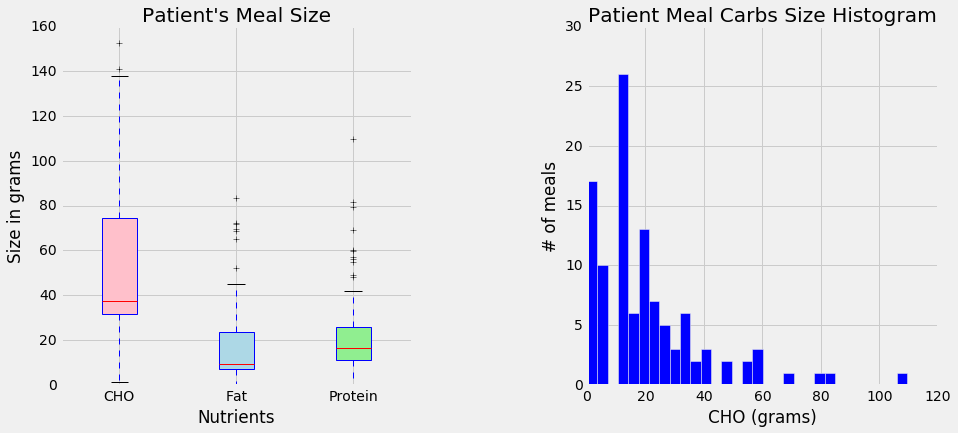

For this patient, the meal Carbs mean is: 50.75 grams with a std of: 32.16 grams.


In [138]:
bins =  int(math.ceil(np.max(df_P_meals['CHO (g)'])/5))#bins of 5 grams

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
######################Box Plot
# rectangular box plot
bplot1 = axes[0].boxplot([df_P_meals['CHO (g)'],df_P_meals['Fat (g)'], df_P_meals['Protein (g)']],
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)
# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# add x-tick labels
plt.setp(axes[0], xticks=[y+1 for y in range(3)],
         xticklabels=['CHO', 'Fat', 'Protein'])

axes[0].set_xlabel('Nutrients')
axes[0].set_ylabel('Size in grams')
axes[0].set_title('Patient\'s Meal Size')

#####################Histogram of CHO
bplot0 = axes[1].hist(df_P_meals['CHO (g)'], bins, facecolor='blue', alpha=1)
axes[1].set_xlabel('CHO (grams)')
axes[1].set_ylabel('# of meals')
axes[1].set_title('Patient Meal Carbs Size Histogram')
fig.subplots_adjust(wspace=0.5)

plt.show()

#n, bins, patches = plt.hist(df_P_meals['CHO (g)'], bins, facecolor='blue', alpha=1)

print "For this patient, the meal Carbs mean is:", round(np.mean(df_P_meals['CHO (g)']),2), "grams with a std of:",round(np.std(df_P_meals['CHO (g)']),2), "grams."

# Critical Assumptions for Cleaning Data

## 1. Assumption for Deletion

**a. Delete meal times that have several missing glucose readings and do not have a full glucose plot following them**

We may consider keeping these points later if we are interested on the meal times only and not the postprandial signals following them.

The selected window is under window_size_minutes. i.e: 23 represents a window of (23*5)+5 = 120 mintues

In [48]:
#This chunk of code implements the first condition, which removes the meals that have significant missing successive points
import datetime

df_P_meals_w_deletion = copy.deepcopy(df_P_meals)

#variables
incr = 5 #Data was recorded at 5 minutes increments
#window_size = 23 #This represents window size based on increments of 5.

window_size_minutes = 120# in minutes
window_size = (window_size_minutes / 5) - 1

del_points_df_a = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
points_to_del_a = []

for x in range(df_P_meals_w_deletion['CHO (g)'].size):
    a = df_P_meals_w_deletion['Date'][x]
    b = a
    count = 0
    for j in range(window_size):
        b += datetime.timedelta(minutes=incr)
        reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        try:
            reading.values[0]
        except IndexError:
            #print "Index out of range"
            count +=1 
            continue  
        if (math.isnan(reading.values[0])):
            count +=1
    #If third of the window has missing values, exclude that meal
    if (count > ((window_size+1)/3)):
        print "\nThe meal time at", a, "has", count,"missing readings within its {}".format((window_size+1)*5),"minutes. Thus, it will be removed from the dataset.\n"
        #Put this into a dataframe to plot later with different color
        del_points_df_a = del_points_df_a.append(df_P.loc[df_P['Date'] == a])        
        points_to_del_a.extend([x])  

#Remove the above detected points from dataset
df_P_meals_w_deletion.drop(df_P_meals_w_deletion.index[points_to_del],axis=0,inplace=True)
df_P_meals_w_deletion = df_P_meals_w_deletion.sort(['Date'])
df_P_meals_w_deletion = df_P_meals_w_deletion.reset_index(drop=True)

if (df_P_meals_w_deletion['CHO (g)'].size == df_P_meals['CHO (g)'].size):
    print "There are no meals that need to be excluded, at this stage.\n"

print "There are", df_P_meals_w_deletion['CHO (g)'].size, "remaining meal times recordings.\n" 

#print points_to_del_a

#print_full(df_P_meals_w_deletion)

There are no meals that need to be excluded, at this stage.

There are 109 remaining meal times recordings.



**b. Delete meal times which all following readings are decreasing or have no sign of a significant increase (i.e: 15mg/dl).**

For every glucose reading, we check if there is a significant increase in **its** following "glucose_effect_window" (i.e 45 minutes). 

We start few minutes before the meal was recorded, just in case the meal was recorded few minutes after food intake.

For instance, a reading situated 30 minutes after meal time recording which has a following glucose increase of (15mg/dl in total) after 30minutes will result on keeping that original meal time which was (30mins + 30mins before). Hence, this is a loose assumption but we can make it stricter by changing window variables and increase glucose value.

If no significant increase is apparent, we delete the meal point.

In [148]:
#This chunk of code implements the second constraint, removing meals which do not have a significant postprandial glucose increase
df_P_meals_w_deletion_b = copy.deepcopy(df_P_meals_w_deletion)

#variables
incr = 5 #Data was collected at 5 minutes increments- Do not change this
glucose_effect_window = 45 #Minutes food may take to be reflected on the blood glucose
gl_increase_window = 45 #Minutes from the instance where the glucose is reflected on the blood to significant increase###Change this to higher minutes if glucose increases slowly
pre_recording_mins = 0 #Minutes that may have elapsed before patient has recorded the reading
gl_increase = 15 #15mg/dL increase because we are interested in meals for now, later we can include sncaks

########May want to change VARIABLES above for different patients, especially if food takes a while to affect their glucose level############

meal_affect_window = [i for i in np.arange(-(pre_recording_mins), glucose_effect_window+incr, incr)]

compare_window = [j for j in np.arange(incr, gl_increase_window+incr, incr)]

points_to_del_b = []
del_points_df_b = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
low_surrounding_gl = pd.DataFrame()#Dataframe containing points where the glucose will go to take a significant increase, not necessarily the very lowest points
high_surrounding_gl = pd.DataFrame()
offset_low_point_to_meal = []

for x, item in enumerate(df_P_meals_w_deletion_b['Date']):
    
    a = df_P_meals_w_deletion_b['Date'][x]
    meal_reading = df_P.loc[df_P['Date'] == item]['mg/dL']
    b = item - datetime.timedelta(minutes=pre_recording_mins) 
    keep = 0
    
    for i in meal_affect_window:
        current_reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        try:
            current_reading.values[0]
        except IndexError:
            #print "Index out of range"
            b += datetime.timedelta(minutes=incr)   
            continue            
        if (math.isnan(current_reading.values[0])):
            b += datetime.timedelta(minutes=incr)  
            continue      
            
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P.loc[df_P['Date'] == c]['mg/dL']
            if ((compare_reading.values[0] - current_reading.values[0]) >=gl_increase):
                #print "We should keep this reading"
                #Store this reading on a dataframe of low readings surrounding meals
                low_surrounding_gl = low_surrounding_gl.append(df_P.loc[df_P['Date'] == b])
                high_surrounding_gl = high_surrounding_gl.append(df_P.loc[df_P['Date'] == c])
                #print "a is:", a, "and b is:", b, "and c is:", c, "and difference between b and c is:", (c - b)
                if (b<item):
                    offset_low_point_to_meal.extend([int(-(item-b).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "-", (a-b).seconds / 60 ,"minutes."        
                else:
                    offset_low_point_to_meal.extend([int((b-item).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "+", (b-a).seconds / 60 ,"minutes."  
                #offset_low_point_to_meal.extend([offset_seconds])
                keep = 1  
                break
                
        if (keep == 1):
            break
        b += datetime.timedelta(minutes=incr)    
        
        if (i == meal_affect_window[-1]):
            #print "The meal reading taken at" ,a, "should be deleted."
            
            #print "The reading that is about to be removed has the following size, CHO", round(df_P_meals_w_deletion_b['CHO (g)'][x],2),"g, Proteins", round(df_P_meals_w_deletion_b['Protein (g)'][x],2),"g, Fats", round(df_P_meals_w_deletion_b['Fat (g)'][x],2),"g"
            #Put this into an dataframe to plot with different color
            del_points_df_b = del_points_df_b.append(df_P.loc[df_P['Date'] == item])
            #Also remove this from dataset   
            points_to_del_b.extend([x]) 

#Switch to this part of the code            
#######Add this portion of the code, if we wan to keep all meals that are above a certain treshold 
#             #if th emeal size is larger than certain value, keep regardless. For instance, cho > 20grams, or proteins > 10grams, or fats > 10 grams        
#             if(df_P_meals_w_deletion_b['CHO (g)'][x]>20 or df_P_meals_w_deletion_b['Protein (g)'][x]>10 or df_P_meals_w_deletion_b['Fat (g)'][x]>10):
#                 break
#             else:
#                 #Put this into an dataframe to plot with different color
#                 del_points_df_b = del_points_df_b.append(df_P.loc[df_P['Date'] == item])
#                 #Also remove this from dataset   
#                 points_to_del_b.extend([x])      
#############################################################

#print "\nThe dataframe of the points to be deleted is:\n", del_points_df 
#print (points_to_del)

print "\nThere are", len(points_to_del_b), "meal recordings that will be deleted."

df_P_meals_w_deletion_b.drop(df_P_meals_w_deletion_b.index[points_to_del_b],axis=0,inplace=True)
df_P_meals_w_deletion_b = df_P_meals_w_deletion_b.sort(['Date'])
df_P_meals_w_deletion_b = df_P_meals_w_deletion_b.reset_index(drop=True)

print "\nThere are", df_P_meals_w_deletion_b['CHO (g)'].size, "remaining meal times recordings." 

low_surrounding_gl = low_surrounding_gl.sort(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

high_surrounding_gl = high_surrounding_gl.sort(['Date'])
high_surrounding_gl = high_surrounding_gl.reset_index(drop=True)

df_P_meals_w_deletion_v2 = copy.deepcopy(df_P_meals_w_deletion_b)


There are 34 meal recordings that will be deleted.

There are 75 remaining meal times recordings.


In [107]:
# output to static HTML file, remaining meals, meals to be deleted after assumption a and b
output_file("All_Data_with_Deletion.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P.Date, df_P['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P.Date, df_P['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], z=df_P_meals_w_deletion_v2['CHO (g)'], k = df_P_meals_w_deletion_v2['Fat (g)'], d = df_P_meals_w_deletion_v2['Protein (g)']))
g1 = plot.asterisk(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

if (len(points_to_del_a) != 0):
    plot.asterisk(x=del_points_df_a.Date, y=del_points_df_a['mg/dL'],legend = 'Meal to be deleted after condition a', line_color="#32CD32", fill_color=None, line_width=8)

if (len(points_to_del_b) != 0):    
    plot.asterisk(x=del_points_df_b.Date, y=del_points_df_b['mg/dL'],legend = 'Meal to be deleted after condition b', line_color="#0404B4", fill_color=None, line_width=8)

#plot.asterisk(x=high_surrounding_gl.Date, y=high_surrounding_gl['mg/dL'], legend = 'first increase Points', line_color="#32CD32", fill_color=None, line_width=8)   
#plot.asterisk(x=low_surrounding_gl.Date, y=low_surrounding_gl['mg/dL'], legend = 'first low Points', line_color="#0404B4", fill_color=None, line_width=8)   

#print y
plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 


** Aggregate all reamaining meals into one day.**

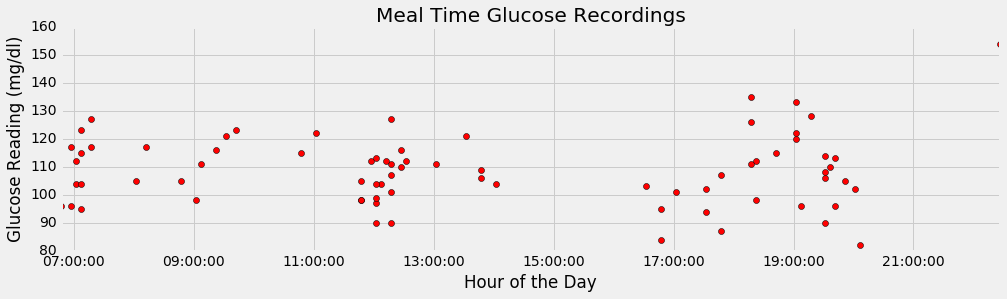

In [91]:
df_P_all_clean_1day = copy.deepcopy(df_P_meals_w_deletion_v2)

d = datetime.datetime.today()
for i in range(len(df_P_all_clean_1day)):
    dt = df_P_all_clean_1day.Date[i].replace(year=d.year, month=d.month, day=d.day)    
    df_P_all_clean_1day.Date[i] = dt

fig = plt.figure(figsize= (15,15))
plt.subplots_adjust(hspace=0.5)

sub1 = fig.add_subplot(311)
sub1.set_xlabel('Hour of the Day')
sub1.set_ylabel('Glucose Reading (mg/dl)')
sub1.set_title('Meal Time Glucose Recordings')
plt.plot_date(df_P_all_clean_1day.Date, df_P_all_clean_1day['mg/dL'], 'ro')  

plt.show()

**This completes the assumptions for deleting abnormal meal points**

In [100]:
#Last non empty row of patient data
nonempty_P_readings = df_P[pd.notnull(df_P['Date'])]

#print nonempty_P1_readings.iloc[-1,nonempty_P1_readings.columns.get_loc('Date')]


**The dataframe that contains the meal times after deletion of abnormal meal recordings is: df_P_meals_w_deletion_v2**

# Detecting peaks following meal times

Steps:

1. Detect a significant glucose drop

2. Find the highest glucose point up to that drop point


In [136]:
#Step 1

gl_decrease = 12 #15mg/dl of glucose drop (we noticed from the data that 10mg/dl would be too low and may result in not finding the highest peak after meal)

minutes2peak = 90#Minutes to reach the peak after meal
gl_decrease_window = 90 #Minutes it takes for a significant glucose decrease after meal, it may take long time for glucose to go down, few hours

up2peak_window = [j for j in np.arange(0, minutes2peak+incr, incr)]
compare_window = [j for j in np.arange(incr, gl_decrease_window+incr, incr)]

#print up2peak_window

afterpeak_lowgl_df = pd.DataFrame()#This dataframe contains the points after the glucose drop following the peak
lowpoint_to_del_df = pd.DataFrame()#Dataframe contaning any meal recording to be deleted because they do not have a significant nearby glucose drop after the increase
peak_points_df = pd.DataFrame()#Dataframe containing peak points following meal times
lowpoint_to_del = []

for x, item in enumerate(high_surrounding_gl['mg/dL']):   
    a = high_surrounding_gl['Date'][x]   
    keep = 0
    b= a

    for i in up2peak_window:

        current_reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        #print "**Following reading:", current_reading.values[0], "at the date of", b          
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P.loc[df_P['Date'] == c]['mg/dL']
            #print "***Compared reading reading:", compare_reading.values[0], " at the date of", c  
            if ((current_reading.values[0] - compare_reading.values[0]) > gl_decrease):#significant glucose drop has been detected
                #Store this reading on a dataframe of points detecting glucose drop after peak
                #print "found it"
                afterpeak_lowgl_df = afterpeak_lowgl_df.append(df_P.loc[df_P['Date'] == c])
                keep = 1
                break
                
        if (keep == 1):
            break   
    
        if (i == up2peak_window[-1]):
            #print "Could not detect a significant glucose drop after this meal recording", df_P_meals_w_deletion_v2['Date'][x], ". It is suggested to delete it"  
            lowpoint_to_del.extend([x])  
            lowpoint_to_del_df = lowpoint_to_del_df.append(df_P.loc[df_P['Date'] == a])
            
        b += datetime.timedelta(minutes=incr)    

afterpeak_lowgl_df = afterpeak_lowgl_df.reset_index(drop=True)
lowpoint_to_del_df = lowpoint_to_del_df.reset_index(drop=True)

print "Could not detect a significant glucose drop after the following meal recordings:\n",lowpoint_to_del_df['Date']
#Drop x from the "all the meals" dataframe 
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[lowpoint_to_del],axis=0,inplace=True)  
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

#print "number of meals are:", df_P1_meals_w_deletion['CHO (g)'].size

#print "afterpeak_lowgl_df size is:", afterpeak_lowgl_df['CHO (g)'].size

#Step 2

#print "\nThe dataframe of the points after detecting a glucose drop:\n", afterpeak_lowgl_df 
def drange(start, stop, step):
    while start <= stop:
            yield start
            start += step
            
#print df_P1.iloc[-2]['Date']
    
for x, item in enumerate(afterpeak_lowgl_df['mg/dL']):
    #print "At the meal of date", df_P1_meals_w_deletion['Date'][x], "the lowest point is at:", surrounding_lowest_points_df['Date'][x] , "and low after peak is at:", afterpeak_lowgl_df['Date'][x]  
    a = df_P_meals_w_deletion_v2['Date'][x]
    #print "x is:", x , "and its date is:", afterpeak_lowgl_df['Date'][x]   
    current_reading = df_P.loc[df_P['Date'] == a]['mg/dL'].values[0]
    lowpt_after_peak = afterpeak_lowgl_df['Date'][x]   
    b= a
    #difference in minutes between lowest point and the point after glucose drop following peak
    window_peak = (lowpt_after_peak-a).seconds / 60
    #print window_peak
    peak_index = 0

    for i in drange(5,window_peak,5):        
        b += datetime.timedelta(minutes=incr)
        if (b <= nonempty_P_readings.iloc[-1,nonempty_P_readings.columns.get_loc('Date')]):
            incrt_reading = df_P.loc[df_P['Date'] == b]['mg/dL'].values[0]   
            if (math.isnan(incrt_reading)):
                b += datetime.timedelta(minutes=incr)  
                continue

            if (incrt_reading > current_reading):
                current_reading = incrt_reading
                peak_index = i
    #print "the peak index is offseted by", peak_index, "minutes from the lowest reading"        
    c = a + datetime.timedelta(minutes=int(peak_index))
    
    peak_points_df = peak_points_df.append(df_P.loc[df_P['Date'] == c])

peak_points_df = peak_points_df.reset_index(drop=True)

#print_full(peak_points_df['Date'])  

#print_full(surrounding_lowest_points_df)

#print peak_points_df 
peak_elapsed_time = []

#Need to make list with elapsed time between peak and meal recording for plotting, in minutes
for x, item in enumerate(peak_points_df['mg/dL']): 
    meal_recording = df_P_meals_w_deletion_v2['Date'][x]
    peak_reading = peak_points_df['Date'][x]      
    if (peak_reading>=meal_recording):
        topeakduration = (peak_reading-meal_recording).seconds / 60
    else:
        topeakduration = -(meal_recording-peak_reading).seconds / 60       
    peak_elapsed_time.append(int(topeakduration))
    
print "\nThere are", df_P_meals_w_deletion_v2['Date'].size, "remaining readings."


Could not detect a significant glucose drop after the following meal recordings:
0   2008-08-12 18:02:00
1   2008-08-14 12:47:00
2   2008-08-18 20:42:00
Name: Date, dtype: datetime64[ns]

There are 72 remaining readings.
